In [10]:
# phases: explore transition phases

#=============================================================================
# class Cell
# usage: scr = Screen('Neurons',4,10)
#        cell = Cell(scr.at(1,2),k,g,K,P)
#        cell.show()
#=============================================================================

import numpy
from numpy import transpose as trn
from numpy import ones
from carabao.cell import norm1

class Cell:
    def __init__(self,mon,k,g,K,P):
        self.mon = mon
        zero = [0 for i in range(0,P.shape[0])]
        
            # input, output, state variables

        self.u = 0             # basal (feedforwad) input
        self.y = 0             # cell output (axon)
        self.x = 0             # predictive state
        self.b = 0             # burst state
        self.P = P             # permanence matrix (state)
        self.s = zero;

            # parameters and auxilliary variables
        
        self.config(k,g,K)
        self.x_ = 0            # auxilliary: x(t+1)
        self.P_ = self.P       # auxilliary: P(t+1)
        
    def config(self,k,g,K):
        self.eta = 0.5      # synaptic threshold
        self.theta = 2      # dendritic threshold
        self.pdelta = 0.04  # positive learning delata
        self.ndelta = 0.02  # negative learning delta
        self.k = k;
        self.g = g;  
        self.K = K;
        
    def transition(self):              # state & permanence transition
        self.x = self.x_               # predictive state transition
        self.P = self.P_               # permanence state transition

    def update(self,c):                # update context with current output
        c[self.k] = self.y             # update context with changed output
        return c                       # return updated context

    def phase1(self,u,c):              # cell algo phase 1: update context
        self.transition()              # first perform state transition

            # rule 1: excited (u=1) & predictive (x=1) cells get active (y=1)

        self.u = u;                    # store input locally
        self.y = u * self.x            # excited & predictive cells get active
        #self.b = 0                    # clear burst state

            # update context c[k] with updated output y
            # note: c is only updated but not used for processing 
        
            # record/log quantities (if verbose)

        mon.record(self,u,c)           # record current cell state
        return self.update(c)          # return updated context

    def phase2(self,u,c):              # cell algo phase 2: bursting
        self.u = u

           # rule 2: excited cells in a non-predictive group get bursting
        
        self.b,q = self.burst(c)       # determine cell's burst state

           # important: in this phase we cannot change output (and context vector)
           # before all cells in the context have determined their burst state
        
        mon.record(self,u,c,q)
        return self.update(c)          # return updated context
        
    def phase3(self,u,c):              # cell algo phase 3: process context
        self.u = u

            # rule 3: excited bursting cells get active
        
        self.y = self.y or (u * self.b)
       
            # process W,Z,Q,L

        V = self.select(c,self.K)      # pre-synaptic signals
        W = (self.P >= self.eta)       # synaptic (binary) weights
        Q = V * W                      # synapitcs matrix
  
            # spiking cells get predictive (calculate state after transition)

        s = (norm1(Q) >= self.theta)   # dentritic spike 
        self.x_ = u * s                # getting predictive

            # spiking cells learn (calculate permanences after transition)

        L = self.learn(Q)
        D = self.y * (L*Q*self.pdelta - L*self.ndelta)

        self.P_ = self.P + D           # learning (permanences after transition)

            # record this stuff

        mon.record(self,u,c,0,V,W,Q,L,D)
        return self.update(c)          # return updated context

    def phase(self,i,u,c):             # cell algo phase i
        if i == 1:
            return self.phase1(u,c)
        elif i == 2:
            return self.phase2(u,c)
        elif i == 3:
            return self.phase3(u,c)
        else:
            raise Exception("bad phase")

    def select(self,c,K):              # pre-synaptic signals
        V = 0*K
        for mu in range(0,K.shape[0]):
            for nu in range(0,K.shape[1]):
                V[mu,nu] = c[K[mu,nu]];
        return V

    def burst(self,c):
        q = []
        for k in range(0,len(self.g)):
           qk = c[self.g[k]]
           q.append(qk)
        b = int(sum(q) == 0)            # burst state
        return b,q

    def learn(self,Q):                  # learning vector
        d,s = Q.shape
        l = [];  p = []
        for mu in range(0,d):
            norm = sum(Q[mu]).item()
            l.append(norm)
            p.append(int(norm >= self.theta))
        L = trn(array([p])) @ ones((1,s))
        return L

    def plot(self,i=None,j=None):
        mon.plot(self,i,j)
        
       


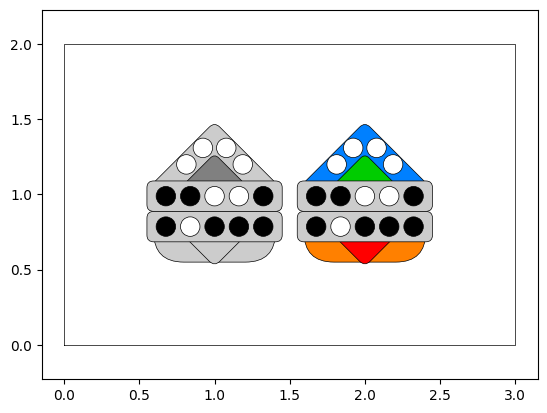

In [11]:
# Test Monitor

from carabao.screen import Monitor
from numpy import array

k = 0                        # cell index
g = [0,1,2,3]                # group indices
K = array([[1,3,5,7,9],[3,4,5,6,7]])
P = array([[0.12,0.32,0.54,0.77,0],[0,0.61,0.45,0,0]])

    # create an inactive neuron

mon = Monitor(1,2)
cell = Cell(mon,k,g,K,P)
cell.u = cell.x = cell.y = cell.b = 0
cell.plot(0,0)

cell = Cell(mon,k,g,K,P)
cell.u = cell.x = cell.y = cell.b = 1
cell.plot(0,1)

--------------------------------------------------------------
iteration:  0 cell: #0 (configured)
   k0: 0 , g: [0, 1, 2, 3] , eta: 0.5
   K0: [    1    3    5    7    9;     1    2    3    4    5]
   P0: [  .52  .62  .44  .27    0;     0  .61  .65    0    0]
   u0: 0 , y0: 0 , x0: 0
   c: None
-------------------------------------------------------------
--------------------------------------------------------------
iteration:  0 cell: #1 (configured)
   k1: 1 , g: [0, 1, 2, 3] , eta: 0.5
   K1: [    0    3    4    5    6;     5    6    7    8    9]
   P1: [  .12  .32  .17  .77  .88;     0  .31  .55  .65    0]
   u1: 0 , y1: 0 , x1: 0
   c: None
-------------------------------------------------------------
--------------------------------------------------------------
iteration:  0 cell: #0 (phase 1)
   k0: 0 , g: [0, 1, 2, 3] , eta: 0.5
   K0: [    1    3    5    7    9;     1    2    3    4    5]
   P0: [  .52  .62  .44  .27    0;     0  .61  .65    0    0]
   u0: 1 , y0: 0 , x0: 0

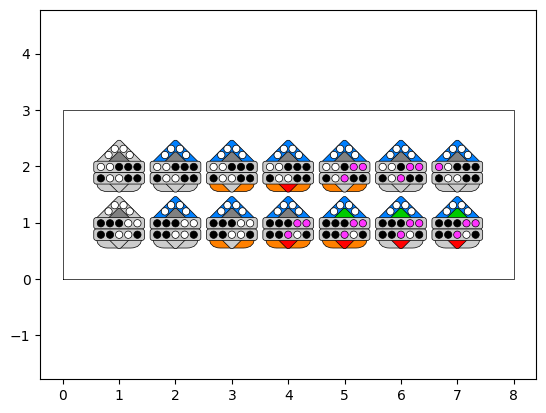

In [12]:
# create inactive neuron 0

from numpy import array

k0 = 0                        # index of our cell
g = [0,1,2,3]                # group indices
K0 = array([[1,3,5,7,9],[1,2,3,4,5]])
P0 = array([[0.52,0.62,0.44,0.27,0],[0,0.61,0.65,0,0]])

# create inactive neuron 1

k1 = 1                        # index of our cell
g = [0,1,2,3]                # group indices
K1 = array([[0,3,4,5,6],[5,6,7,8,9]])
P1 = array([[0.12,0.32,0.17,0.77,0.88],[0,0.31,0.55,0.65,0]])

    # create an inactive neuron

mon = Monitor(2,7,verbose=1)
cell0 = Cell(mon,k0,g,K0,P0)
cell1 = Cell(mon,k1,g,K1,P1)
c = [0,0,0,0,1,1,1,1,0,1]    # context

mon.log(cell0,"(configured)")
mon.log(cell1,"(configured)")
cell0.plot(0,0)
cell1.plot(1,0)

#=======================================================================

# iteration 0 / phase 1: predictive cells update their output

u = 1
c = cell0.phase1(u,c)
cell0.plot(0,1)
c = cell1.phase1(u,c)
cell1.plot(1,1)

# iteration 0 / phase 2: calculate burst state

c = cell0.phase2(u,c)
cell0.plot(0,2)
c = cell1.phase2(u,c)
cell1.plot(1,2)

# iteration 0 / phase 3: calculate other stuff

c = cell0.phase3(u,c)
cell0.plot(0,3)
c = cell1.phase3(u,c)
cell1.plot(1,3)

#=======================================================================


# iteration 1 / phase 1: predictive cells update their output

u = 1
c = cell0.phase1(u,c)
cell0.plot(0,4)
c = cell1.phase1(u,c)
cell1.plot(1,4)

# iteration 1 / phase 2: calculate burst state

c = cell0.phase2(u,c)
cell0.plot(0,5)
c = cell1.phase2(u,c)
cell1.plot(1,5)

# iteration 1 / phase 3: calculate other stuff

c = cell0.phase3(u,c)
cell0.plot(0,6)
c = cell1.phase3(u,c)
cell1.plot(1,6)

